<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_direct_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DirectSolver

In [4]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=000a24465ba812a2570050f5f0e0e5a5ced63e1bb07cd07722722236bdfc8acd
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [5]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.9 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2546f2e37ff22cfdb61276a1f2934ad634d5932e233b274d6b95f1bd0668586c
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [6]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [7]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None


In [8]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 166 (delta 65), reused 44 (delta 5), pack-reused 0
Receiving objects: 100% (166/166), 2.04 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [9]:
cd maestria

/content/maestria


In [10]:
ls

case_studies/  mc_continuous/       ml_batch/            parameter_estimation/
data/          mc_fb/               ml_fb/               README.md
mc_batch/      mc_fb_optimization/  ml_fb_optimization/  utilis/


In [11]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [12]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         upper_limit_x,
                         lower_limit_s,
                         upper_limit_s,
                         lower_limit_p,
                         upper_limit_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device='cpu') 
    ) 
    x0_train[:,0] = x0_train[:,0] * upper_limit_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * upper_limit_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * upper_limit_p + lower_limit_p # product (0-40)
    return x0_train 

In [13]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 10, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 4.7164, 17.5248,  7.4123],
        [ 1.3106, 21.9525, 27.8671],
        [ 6.6276,  8.1339, 20.8072],
        [ 6.5601, 38.9031, 25.0555],
        [ 2.8777, 34.2439,  3.8162]], dtype=torch.float64)
torch.Size([100, 3])


In [14]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 1.9509, 23.5213, 12.9110],
        [ 5.6286,  9.7125, 23.1590],
        [ 5.0365,  2.5232, 37.6279],
        [ 3.6794,  4.5928,  0.7818],
        [ 7.7501, 25.7386, 33.7064]], dtype=torch.float64)
torch.Size([10, 3])


In [15]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

In [16]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

In [17]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

In [18]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")


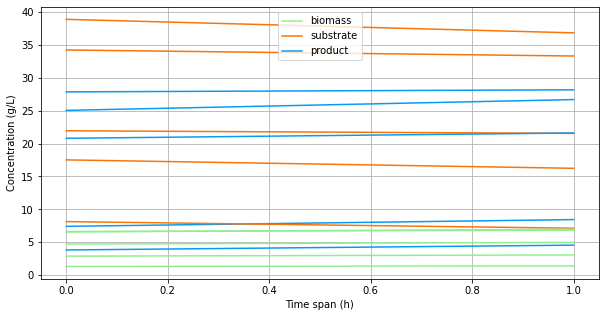

In [19]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [20]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

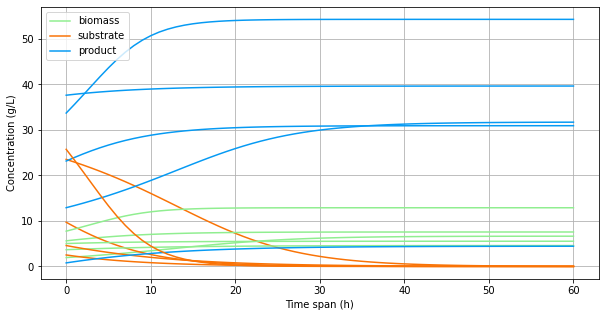

In [21]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [22]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [26]:
# Create model
net = fnn_model(3, 3, 32, 8)

In [27]:
# training algorithm
optimizer = Adam(net.parameters()) 

In [28]:
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=DirectSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver=DirectSolver()
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")


  0%|          | 7/2000 [00:00<01:04, 30.86it/s]

Epoch: 0 | Training loss: 172.26590772723156 | Validate loss: 455.5851267007493


  3%|▎         | 55/2000 [00:01<01:02, 31.03it/s]

Epoch: 50 | Training loss: 14.434322948618128 | Validate loss: 211.35543549883425


  5%|▌         | 107/2000 [00:03<00:56, 33.29it/s]

Epoch: 100 | Training loss: 2.1977716867783865 | Validate loss: 54.385387352520176


  8%|▊         | 155/2000 [00:04<00:53, 34.46it/s]

Epoch: 150 | Training loss: 0.25626735892873537 | Validate loss: 65.17351876786887


 10%|█         | 207/2000 [00:06<00:52, 34.13it/s]

Epoch: 200 | Training loss: 0.06530871994826029 | Validate loss: 139.79254050205353


 13%|█▎        | 255/2000 [00:07<00:52, 33.56it/s]

Epoch: 250 | Training loss: 0.026501278262311263 | Validate loss: 601.7699473567045


 15%|█▌        | 307/2000 [00:09<00:50, 33.66it/s]

Epoch: 300 | Training loss: 0.013977481385554805 | Validate loss: 816.4714441589134


 18%|█▊        | 355/2000 [00:10<00:46, 35.38it/s]

Epoch: 350 | Training loss: 0.013049383878839192 | Validate loss: 744.7948576409904


 20%|██        | 403/2000 [00:12<00:51, 31.21it/s]

Epoch: 400 | Training loss: 0.006819573531603874 | Validate loss: 1152.3733882163444


 23%|██▎       | 458/2000 [00:13<00:48, 31.68it/s]

Epoch: 450 | Training loss: 0.00573750298508486 | Validate loss: 1216.789619243476


 25%|██▌       | 506/2000 [00:15<00:43, 34.30it/s]

Epoch: 500 | Training loss: 0.005114057270338413 | Validate loss: 878.6987593050023


 28%|██▊       | 558/2000 [00:16<00:42, 34.29it/s]

Epoch: 550 | Training loss: 0.004198698772910929 | Validate loss: 837.5762451986104


 30%|███       | 606/2000 [00:18<00:41, 33.86it/s]

Epoch: 600 | Training loss: 0.003155679412274385 | Validate loss: 828.3585104798863


 33%|███▎      | 658/2000 [00:19<00:37, 35.37it/s]

Epoch: 650 | Training loss: 0.007416831923977662 | Validate loss: 725.3315044234006


 35%|███▌      | 706/2000 [00:21<00:38, 33.85it/s]

Epoch: 700 | Training loss: 0.0025180866186647875 | Validate loss: 688.3515407890239


 38%|███▊      | 758/2000 [00:22<00:35, 35.30it/s]

Epoch: 750 | Training loss: 0.0020865197072827864 | Validate loss: 595.5649860263062


 40%|████      | 806/2000 [00:23<00:34, 34.80it/s]

Epoch: 800 | Training loss: 0.03240913131798867 | Validate loss: 204.7669495425248


 43%|████▎     | 858/2000 [00:25<00:33, 34.24it/s]

Epoch: 850 | Training loss: 0.001852535686688606 | Validate loss: 416.8471645773605


 45%|████▌     | 906/2000 [00:26<00:33, 32.61it/s]

Epoch: 900 | Training loss: 0.0015173895738999632 | Validate loss: 316.5376726762812


 48%|████▊     | 958/2000 [00:28<00:31, 33.42it/s]

Epoch: 950 | Training loss: 0.0013686809310530694 | Validate loss: 217.50596225562106


 50%|█████     | 1006/2000 [00:29<00:27, 35.66it/s]

Epoch: 1000 | Training loss: 0.0015791606459289109 | Validate loss: 248.04403656408158


 53%|█████▎    | 1054/2000 [00:31<00:27, 34.47it/s]

Epoch: 1050 | Training loss: 0.0012632468393580553 | Validate loss: 171.47916405988565


 55%|█████▌    | 1106/2000 [00:32<00:26, 33.81it/s]

Epoch: 1100 | Training loss: 0.0011357593358814935 | Validate loss: 97.62409476833098


 58%|█████▊    | 1155/2000 [00:34<00:24, 34.50it/s]

Epoch: 1150 | Training loss: 0.0010515529449744102 | Validate loss: 71.45289928078401


 60%|██████    | 1207/2000 [00:35<00:23, 34.36it/s]

Epoch: 1200 | Training loss: 0.0009821664636584895 | Validate loss: 56.91388048142421


 63%|██████▎   | 1254/2000 [00:37<00:27, 27.48it/s]

Epoch: 1250 | Training loss: 0.00468199276134806 | Validate loss: 164.85667963763234


 65%|██████▌   | 1308/2000 [00:38<00:19, 34.64it/s]

Epoch: 1300 | Training loss: 0.0012236558649714325 | Validate loss: 58.265453498157775


 68%|██████▊   | 1356/2000 [00:40<00:18, 34.17it/s]

Epoch: 1350 | Training loss: 0.0009167418804045402 | Validate loss: 46.5797714260274


 70%|███████   | 1404/2000 [00:41<00:18, 32.99it/s]

Epoch: 1400 | Training loss: 0.0008520910452615523 | Validate loss: 38.11008476169456


 73%|███████▎  | 1456/2000 [00:43<00:16, 33.70it/s]

Epoch: 1450 | Training loss: 0.0008032008811768251 | Validate loss: 32.339470637330635


 75%|███████▌  | 1508/2000 [00:44<00:14, 34.37it/s]

Epoch: 1500 | Training loss: 0.0007611142592289917 | Validate loss: 27.902442388047724


 78%|███████▊  | 1556/2000 [00:46<00:12, 35.14it/s]

Epoch: 1550 | Training loss: 0.0007235978206925919 | Validate loss: 24.249065046962937


 80%|████████  | 1604/2000 [00:47<00:11, 35.03it/s]

Epoch: 1600 | Training loss: 0.00965701494021436 | Validate loss: 80.47019598764513


 83%|████████▎ | 1656/2000 [00:49<00:10, 34.07it/s]

Epoch: 1650 | Training loss: 0.0008323110662461284 | Validate loss: 27.673315266891105


 85%|████████▌ | 1708/2000 [00:50<00:08, 35.01it/s]

Epoch: 1700 | Training loss: 0.000738044234596794 | Validate loss: 22.920005620620085


 88%|████████▊ | 1756/2000 [00:52<00:07, 33.66it/s]

Epoch: 1750 | Training loss: 0.0006858552748267383 | Validate loss: 19.692985681728302


 90%|█████████ | 1808/2000 [00:53<00:05, 35.28it/s]

Epoch: 1800 | Training loss: 0.0006460052704816398 | Validate loss: 17.25728071823298


 93%|█████████▎| 1856/2000 [00:54<00:04, 32.66it/s]

Epoch: 1850 | Training loss: 0.0006122242251545999 | Validate loss: 15.294256579728314


 95%|█████████▌| 1908/2000 [00:56<00:02, 34.73it/s]

Epoch: 1900 | Training loss: 0.0005821818729232162 | Validate loss: 13.613437583459339


 98%|█████████▊| 1956/2000 [00:57<00:01, 36.19it/s]

Epoch: 1950 | Training loss: 0.0005547675764121722 | Validate loss: 13.108611725394251


100%|██████████| 2000/2000 [00:59<00:00, 33.78it/s]


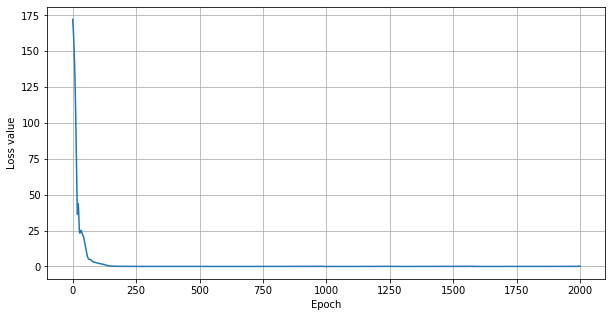

In [29]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [30]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=DirectSolver()
    ) 

In [31]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [32]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [37]:
def plot_predictions(n=0):

    print("Validación", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validación 0


<ipython-input-37-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-37-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-37-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

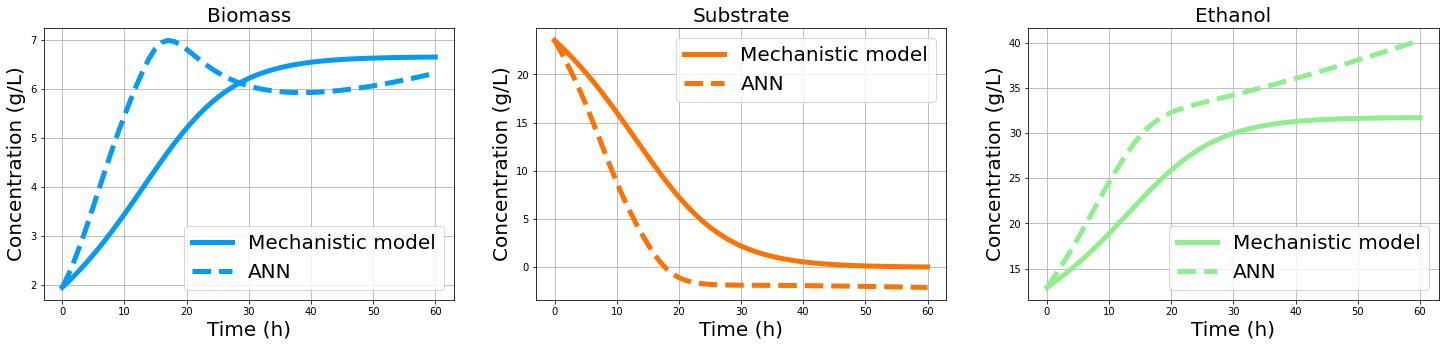

Validación 1


<ipython-input-37-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-37-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-37-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

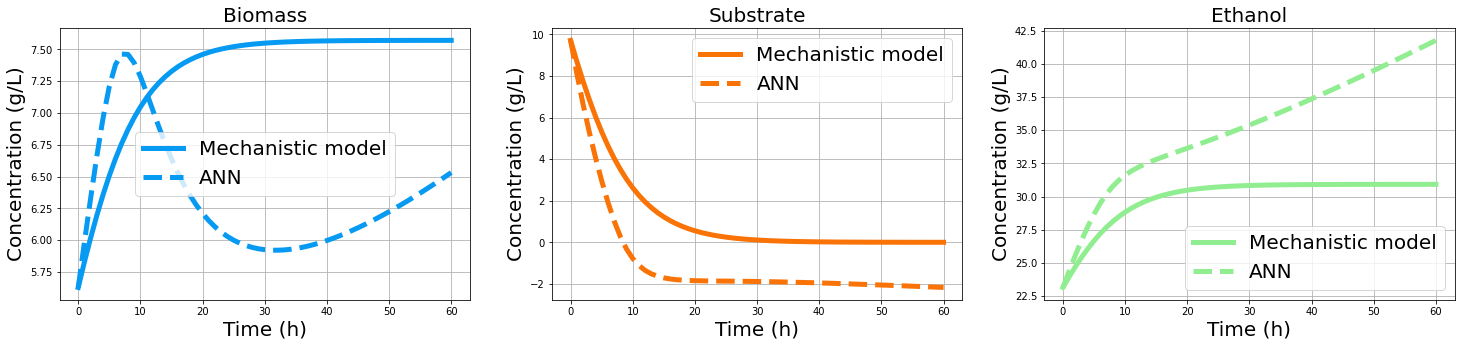

Validación 2


<ipython-input-37-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-37-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-37-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

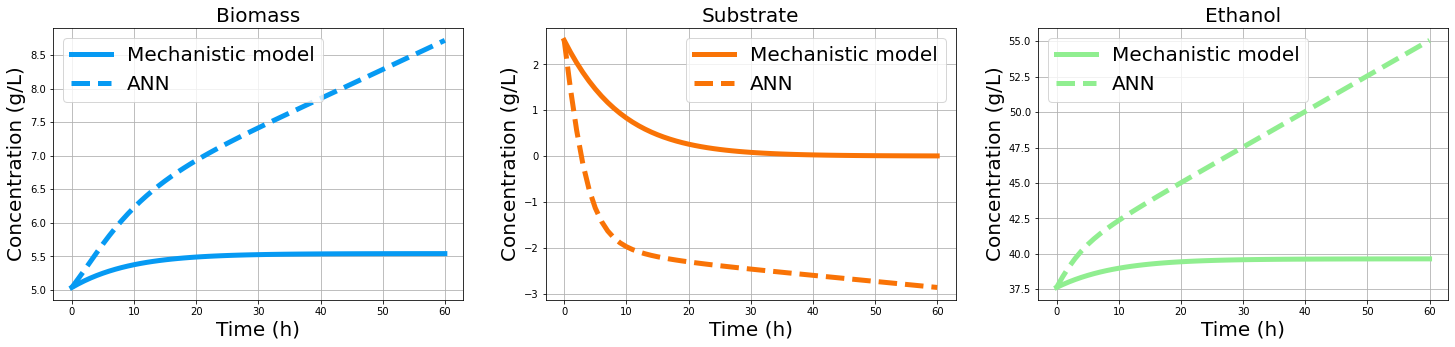

Validación 3


<ipython-input-37-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-37-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-37-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

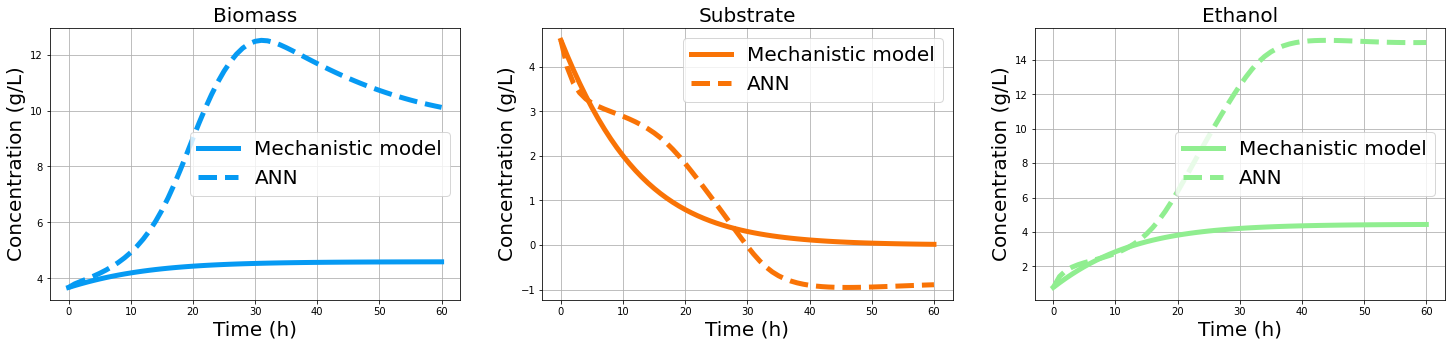

Validación 4


<ipython-input-37-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-37-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-37-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

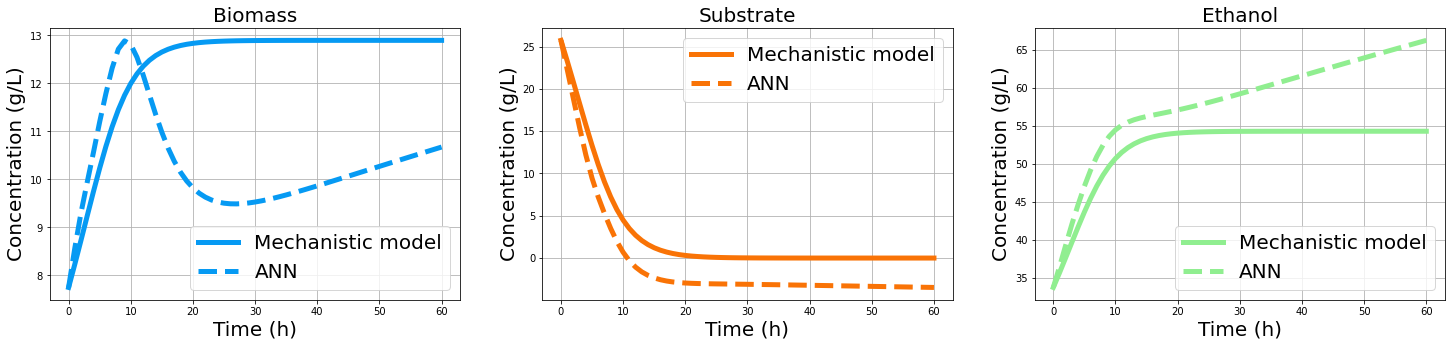

In [38]:
for i in range(5):
    plot_predictions(i)